# Test Sample for Our Signature Recogntion Trained Model!


# Evan Ackerman
# Patrick Schlosser

## importing all necessary libraries

In [1]:
# Imports and Data
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import math
import random
# for converting data to tensors before feeding into network
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from google.colab.patches import cv2_imshow
from google.colab import drive

from tqdm import tqdm

#**IMPORTANT**

The path is too large to upload to GitHub so a path needs to be used to load the trained weights. We have updated the sharing access of the weights from Google Drive. Its in the TEST.txt file

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# You can manually add these test images to the run time after downloading them from GitHub

In [3]:
IMG1 = "TEST_FAKE.jpg" # REAL SIGNATURE
IMG2 = "TEST_REAL.jpg" # FORGED SIGNATURE

# Pre-processing Sample

In [4]:
# Data Preprocessing
def load_image(image_path):
    src = cv2.imread(image_path)
    #print(src)
    return src

def convert_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def display_image(image):
    cv2_imshow(image)

def resize_image(image, width, height):
    '''
    Resizes the image to the dimensions that we want (e.g. 250x70)
    '''
    resized_image = cv2.resize(image, (width, height))
    return resized_image


In [5]:
img1 = load_image(IMG1)
img1 = resize_image(img1, 200, 75)

img2 = load_image(IMG2)
img2 = resize_image(img2, 200, 75)

In [6]:
def display_tensors(data_tensor0, data_tensor1):
    '''Display tensor data of an image as an image'''
    numpy_img0 = data_tensor0
    numpy_img1 = data_tensor1
    if numpy_img0.shape[0] == 3:
        numpy_img0 = np.transpose(numpy_img0, (1, 2, 0))
    if numpy_img1.shape[0] == 3:
        numpy_img1 = np.transpose(numpy_img1, (1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(numpy_img0)
    plt.title('Real Signature')
    plt.subplot(1, 2, 2)
    plt.imshow(numpy_img1)
    plt.title('Forged Signature')
    plt.show()

# DATA LOADER

In [7]:
class SiameseDataset(Dataset):
    def __init__(self, genuine_tups, forged_tups):
        '''a tuple is an (image, title) pair'''
        super().__init__()
        self.dataset = self.create_dataset(genuine_tups, forged_tups)


    def create_dataset(self, genuine, forged):
        ''' we want half the images to match'''
        dataset = []

        # we add genuine pairs first
        '''for img, title in genuine:
            found = False
            id, version, rotation = title[:3], title[3:5], title[5:9] # get whose signature it is
            # first see if we can get a different sample from the same person
            for i,t in genuine:
                if t[:3]==id and t[5:9]==rotation:
                    dataset.append((img, i, 1))
                    found = True
                    break
            if found: continue
            # if we were not able to get a different sample, just get a rotation
            for i,t in genuine:
                if t[:3]==id and title!=t:
                    dataset.append((img, i, 1))
                    found = True
                    break
            print(f"No matching genuine picture found for person {id} ({title})")'''

        # now we add forged pairs first - I am going to keep all real images on the left
        for img, title in forged:
            id, version, rotation = title[:3], title[3:5], title[5:9] # get whose signature it is
            for i,t in genuine: # find a matching enuine sample
                dataset.append((i, img, 0))
                break
        random.shuffle(dataset)
        return dataset

    def __getitem__(self, index):
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)

# ARCHITECTURE

In [8]:
class SiameseNetwork(nn.Module):
    '''
    Siamese Network module
    '''
    # self.contrastive_loss = 0.5*(1-Y)*(Dw**2) + 0.5*Y*(max(0,m-Dw))**2
    # self.Dw = lambda x1,x2: math.sqrt(math.pow(Gw(x1)-Gw(x2),2))

    threshold = 30
    threshold_lr = 0.01

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Assuming input images are of size [3, 75, 200]
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(4)
        )


        self.fc1 = nn.Sequential(
            nn.Linear(640, 4096),
            nn.ReLU(),
            nn.Dropout(0.2),  # lowered dropout
            nn.Linear(4096, 1)
        )


    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size(0), -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

    def evaluate(self, dataloader):
        # Switch the network to evaluation mode
        self.eval()
        eval_loss = ContrastiveLoss()

        correct_pairs = 0
        total_pairs = 0

        match_pairs = 0
        forged_pairs = 0
        match_distances = []
        forged_distances = []
        curr_epoch_loss = 0
        # Iterate over the data loader
        for batch in dataloader:
            img_list_0, img_list_1, labels = batch # so store each item of the batch
            for i in range(dataloader.batch_size): # for each pair in batch
                img0 = img_list_0[i]
                img1 = img_list_1[i]
                label = labels[i]
                img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

                # do a prediction
                output1, output2 = self.forward(img0.unsqueeze(0),img1.unsqueeze(0))
                # Calculate the Euclidean distance between the outputs
                distance = F.pairwise_distance(output1, output2)

                # Check if the distance is less than a threshold for similar pairs
                # print("{:.5e} {}".format(torch.mean(distance).item(), label.item()))
                prediction = torch.mean(distance).item() > self.threshold
                label = label.item()
                loss_contrastive = eval_loss(output1,output2, labels[i].cuda(), euclidean_distance=distance)

                curr_epoch_loss += loss_contrastive.detach().cpu().numpy()
                if label == int(prediction):
                    correct_pairs+=1
                total_pairs += 1
                print("1: Match   0: Forged\n")

                if prediction:
                    prediction = "Match"
                else:
                    prediction = "Forgery"

                if label:
                    p = "Match"
                else:
                    p = "Forgery"

                print(f'Predicted: {prediction}')
                print(f'Actual: {p}')

                if label:
                    match_pairs += 1
                    match_distances.append(torch.mean(distance).item())
                else:
                    forged_pairs += 1
                    forged_distances.append(torch.mean(distance).item())

        accuracy = 1.0*correct_pairs / total_pairs
        # print(f"Accuracy is: {accuracy}")
        return accuracy, curr_epoch_loss

    def evaluate_one(self, img0, img1, label):
        self.eval()
        # do a prediction
        output1, output2 = self.forward(img0.unsqueeze(0),img1.unsqueeze(0))
        # Calculate the Euclidean distance between the outputs
        distance = F.pairwise_distance(output1, output2)

        # Check if the distance is less than a threshold for similar pairs
        prediction = torch.mean(distance).item() < self.threshold

        if label == int(prediction):
            return 1
        return 0

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    https://medium.com/hackernoon/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    """

    def __init__(self, margin=40.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label, euclidean_distance=None):
        if not euclidean_distance:
          euclidean_distance = F.pairwise_distance(output1, output2)
        # print(f"match? {label}; distance: {euclidean_distance.item()}")
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

# RUN TEST SAMPLE

## Again like the Part 3 Code: the weights are too large to manually upload into run time, so the code will prompt you for the path of weights from Drive. Apologies again for any inconvience we think this is probably the easiest way

Enter Path to Starting Weights: /content/drive/MyDrive/Handwriting Recognition/50_EPOCH_MODEL.pth
Loading the weights from /content/drive/MyDrive/Handwriting Recognition/50_EPOCH_MODEL.pth ...


Successfully loaded the model checkpoint!


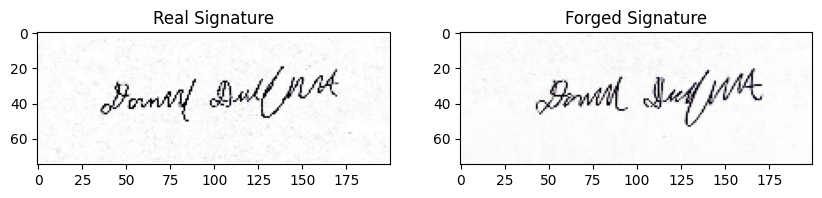

1: Match   0: Forged

Predicted: Forgery
Actual: Forgery

Accuracy (100% or 0% since one sample): 100.0%


In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_starting_weights = input('Enter Path to Starting Weights: ')
load = True

# Loading Trained Weights
network = SiameseNetwork().cuda()
if load:
  print(f"Loading the weights from {my_starting_weights} ...")
  network.load_state_dict(torch.load(my_starting_weights))
  print("Successfully loaded the model checkpoint!")

# The Test Data Sample
# One Sample given from Test
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # normalization of pixel values
])

g_images = []
f_images = []
# Load Real Image (INSERT INTO RUN TIME ON LEFT, path is in an above cell)
img1_loaded = load_image(IMG1)
img1_transformed = transform(img1) # transfrom image to Tensor
g_images.append((img1_transformed, IMG1))

# Load Forged Image (INSERT INTO RUN TIME ON LEFT, path is in an above cell)
img2_loaded = load_image(IMG2)
img2_transformed = transform(img2) # transfrom image to Tensor
f_images.append((img2_transformed, IMG2)) # append file and file name

display_tensors(g_images[0][0], f_images[0][0])

test_data = SiameseDataset(g_images, f_images)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True) # get test sample in

acc, loss = network.evaluate(test_dataloader) # evaluate the sample
print(f'\nAccuracy (100% or 0% since one sample): {acc*100}%')